In [31]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
%autoreload

import warnings
import os.path
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import geopy
import xgboost as xgb
import os
import shutil

from shapely import wkt
from retail_revenue_xgb import generate_features, create_buffer
from sklearn.model_selection import train_test_split
from utils import squared_log, rmsle
from xgboost import plot_importance, to_graphviz

pd.options.mode.chained_assignment = None  # default='warn'


In [33]:
spatial = pd.read_csv('data/grunnkrets_norway_stripped.csv')
age = pd.read_csv('data/grunnkrets_age_distribution.csv')
income = pd.read_csv('data/grunnkrets_income_households.csv')
households = pd.read_csv('data/grunnkrets_households_num_persons.csv')
submission = pd.read_csv('data/sample_submission.csv')
plaace = pd.read_csv('data/plaace_hierarchy.csv')
busstops = pd.read_csv('data/busstops_norway.csv')


def generate_features(df: pd.DataFrame):
    features = ['year', 'store_name', 'mall_name', 'chain_name', 'address', 'lat', 'lon',
                'plaace_hierarchy_id', 'grunnkrets_id']
    df = df[features]
    df['store_name'] = df['store_name'].astype('category')
    # df['store_id'] = df['store_id'].astype('category')
    df['address'] = df['address'].astype('category')
    df['chain_name+mall_name'] = (df['chain_name'] + df['mall_name']).astype('category')
    df['mall_name'] = df['mall_name'].astype('category')
    df['chain_name'] = df['chain_name'].astype('category')
    df['plaace_hierarchy_id'] = df['plaace_hierarchy_id'].astype('category')

    # attempt to difference the lat and lon values, as they seem to be somewhat trending negatively.
    df['lon'] = df['lon'].diff()
    df['lat'] = df['lat'].diff()

    # remove duplicates and merge with the spatial data.
    spatial.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, spatial.drop_duplicates(subset=['grunnkrets_id']), how='left')
    df['grunnkrets_name'] = df['grunnkrets_name'].astype('category')
    df['district_name'] = df['district_name'].astype('category')
    df['municipality_name'] = df['municipality_name'].astype('category')
    df['geometry'] = df['geometry'].astype('category')

    # age.drop_duplicates(subset=['grunnkrets_id'])
    # df = pd.merge(df, age.drop_duplicates(subset=['grunnkrets_id']), how='left')

    income.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, income.drop_duplicates(subset=['grunnkrets_id']), how='left')

    households.drop_duplicates(subset=['grunnkrets_id'])
    df = pd.merge(df, households.drop_duplicates(subset=['grunnkrets_id']), how='left')

    plaace.drop_duplicates(subset=['plaace_hierarchy_id'])
    df = pd.merge(df, plaace.drop_duplicates(subset=['plaace_hierarchy_id']), how='left')
    df['plaace_hierarchy_id'] = df['plaace_hierarchy_id'].astype('category')
    df['sales_channel_name'] = df['sales_channel_name'].astype('category')
    df['lv1_desc'] = df['lv1_desc'].astype('category')
    df['lv2_desc'] = df['lv2_desc'].astype('category')
    df['lv3'] = df['lv3'].astype('category')
    df['lv3_desc'] = df['lv3_desc'].astype('category')
    df['lv4'] = df['lv4'].astype('category')
    df['lv4_desc'] = df['lv4_desc'].astype('category')

    df = df.drop(columns=['grunnkrets_id', 'plaace_hierarchy_id'])

    return df


train = pd.read_csv('data/stores_train.csv')
test = pd.read_csv('data/stores_test.csv')

label_name = 'revenue'
X = train.drop(columns=[label_name])
y = train[label_name]

submission = pd.read_csv('data/sample_submission.csv')
model_to_load = "modeling/0002.model"

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.8)

X_train, X_val = generate_features(X_train), generate_features(X_val)


In [34]:
# Clear buffers
folder = os.path.join(os.getcwd(), 'modeling')
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        print(f'Deleted file: {file_path}')

train_buffer_path = 'modeling/train.buffer'
test_buffer_path = 'modeling/test.buffer'

dtrain = xgb.DMatrix(data=X_train, label=y_train, enable_categorical=True)
dtrain.save_binary(train_buffer_path)
print(f'--> {train_buffer_path} created and saved.')

dvalid = xgb.DMatrix(data=X_val, label=y_val, enable_categorical=True)
dvalid.save_binary(test_buffer_path)
print(f'--> {test_buffer_path} created and saved.')


Deleted file: c:\dev\maskin\maskinprosjekt\modeling\0002.model
Deleted file: c:\dev\maskin\maskinprosjekt\modeling\test.buffer
Deleted file: c:\dev\maskin\maskinprosjekt\modeling\train.buffer
--> modeling/train.buffer created and saved.
--> modeling/test.buffer created and saved.


In [43]:
# check if there already exists a model.
if os.path.exists(model_to_load):
    print("\nModel found, attempting to load.")
    bst = xgb.Booster({'nthread': 4, 'disable_default_eval_metric': True})  # init model
    bst.load_model(model_to_load)  # load data
    print("--> model successfully loaded.")
else:
    print("\nNo model found. Attempt at creating a new one will now start:")
    print("Attempting to initialize parameters for training...")
    params = {
        'max_depth': 10, 
        'eta': 0.1, 
        'disable_default_eval_metric': True
    }
    num_round = 1000

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

    print("--> parameters for training initialized.")

    # print("Attempting to start training...")
    # bst = xgb.train(
    #     params=params, 
    #     dtrain=dtrain, 
    #     num_boost_round=num_round, 
    #     obj=squared_log,
    #     custom_metric=rmsle,
    #     evals=watchlist, 
    #     early_stopping_rounds=10, 
    #     verbose_eval=50)
    # print("--> model trained.")

    # print("Attempting to save model...")
    # bst.save_model(model_to_load)
    # print("--> model saved.")

    print("Starting k-fold cross validaition...")
    res = xgb.cv(params, dtrain, num_boost_round=100, nfold=10, seed=0, obj=squared_log, feval=rmsle,
                   verbose_eval=True, 
                   callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False)])
    print(res)



No model found. Attempt at creating a new one will now start:
Attempting to initialize parameters for training...
--> parameters for training initialized.
Starting k-fold cross validaition...


c:\Users\oskar\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	train-RMSLE:1.52356	test-RMSLE:1.52483
[0]	train-RMSLE:1.52356+0.00425	test-RMSLE:1.52483+0.01727
[1]	train-RMSLE:1.48244	test-RMSLE:1.48514
[1]	train-RMSLE:1.48244+0.00416	test-RMSLE:1.48514+0.01720
[2]	train-RMSLE:1.44251	test-RMSLE:1.44678
[2]	train-RMSLE:1.44251+0.00408	test-RMSLE:1.44678+0.01711
[3]	train-RMSLE:1.40378	test-RMSLE:1.40963
[3]	train-RMSLE:1.40378+0.00400	test-RMSLE:1.40963+0.01700
[4]	train-RMSLE:1.36626	test-RMSLE:1.37382
[4]	train-RMSLE:1.36626+0.00389	test-RMSLE:1.37382+0.01694
[5]	train-RMSLE:1.32999	test-RMSLE:1.33931
[5]	train-RMSLE:1.32999+0.00377	test-RMSLE:1.33931+0.01698
[6]	train-RMSLE:1.29495	test-RMSLE:1.30617
[6]	train-RMSLE:1.29495+0.00366	test-RMSLE:1.30617+0.01699
[7]	train-RMSLE:1.26115	test-RMSLE:1.27431
[7]	train-RMSLE:1.26115+0.00353	test-RMSLE:1.27431+0.01694
[8]	train-RMSLE:1.22858	test-RMSLE:1.24374
[8]	train-RMSLE:1.22858+0.00344	test-RMSLE:1.24374+0.01689
[9]	train-RMSLE:1.19721	test-RMSLE:1.21451
[9]	train-RMSLE:1.19721+0.00331	test-RM

KeyboardInterrupt: 

In [ ]:
# X_test = generate_features(test)
# dtest = xgb.DMatrix(data=X_test, enable_categorical=True)

# print("\nAttempting to start prediction...")
# y_pred = bst.predict(dtest, ntree_limit=bst.best_iteration)
# print("--> Prediction finished.")

# print("\nAttempting to save prediction...")
# submission['predicted'] = np.array(y_pred)
# submission.to_csv('submissions/submission.csv', index=False)
# print("--> prediction saved with features as name in submission folder.")

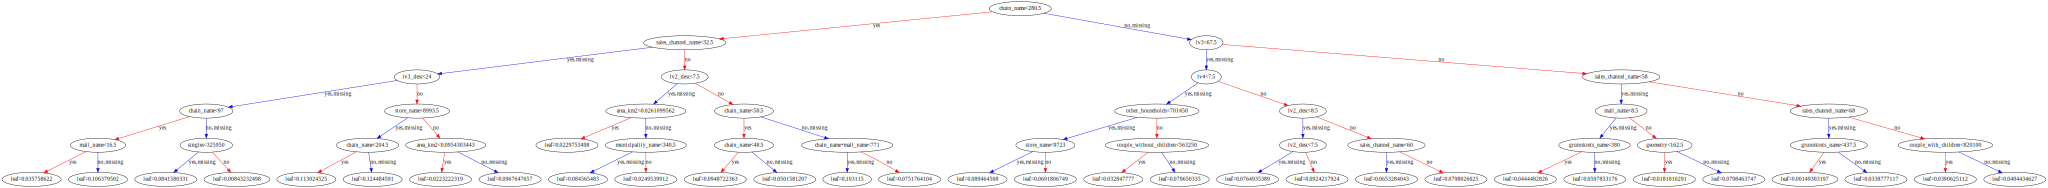

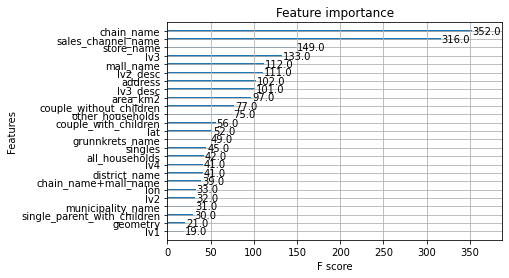

In [30]:
from xgboost import plot_tree

plot_importance(bst)
xgb.to_graphviz(bst, num_trees=1)
# fig, ax = plt.subplots(figsize=(30, 30))
# xgb.plot_tree(bst, num_trees=1, ax=ax)
# plt.savefig("temp.pdf")
# plt.show()
